# Assignment 3

**Assignment 3: Evolutionary Algorithms**

**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

In this assignment, we are going to learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [1]:
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

EPS = 1.0e-7

In [2]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us
# an evaluation of given parameter values.
class Repressilator(object):
    def __init__(self, y_real, params):
        super().__init__()
        self.y_real = y_real.copy()
        self.params = params.copy()

    # The definition of the gene repressilator model as a system of ODEs.
    def repressilator_model(self, t, y):
        m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

        alpha0 = self.params["alpha0"]
        n = self.params["n"]
        beta = self.params["beta"]
        alpha = self.params["alpha"]

        dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
        dp1_dt = -beta * (p1 - m1)
        dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
        dp2_dt = -beta * (p2 - m2)
        dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
        dp3_dt = -beta * (p3 - m3)

        return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

    # A numerial solver for the model (here we use Runge-Kutta 4.5)
    def solve_repressilator(self):
        # we need to use lambda function if we want to pass some parameters
        solution = solve_ivp(
            lambda t, y: self.repressilator_model(t, y),
            t_span=(self.params["t0"], self.params["t1"]),
            y0=self.params["y0"],
            method="RK45",
            t_eval=self.params["t_points"],
        )
        y_points = np.asarray(solution.y)
        return self.params["t_points"], y_points

    # An auxiliary function: setting parameters.
    def set_params(self, x):
        self.params["alpha0"] = x[0]
        self.params["n"] = x[1]
        self.params["beta"] = x[2]
        self.params["alpha"] = x[3]

    # Calculating the objective function.
    # Here, we use the Euclidean distance between the real data and the synthetic data.
    @staticmethod
    def loss(y_real, y_model):
        # we assume only m's are observed!
        y_r = y_real[0:3]
        y_m = y_model[0:3]
        if y_r.shape[1] == y_m.shape[1]:
            return np.mean(np.sqrt(np.sum((y_r - y_m) ** 2, 0)))
        else:
            return np.infty

    def objective(self, x):
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.set_params(xi)

                _, y_model = self.solve_repressilator()
                objective_values.append(self.loss(self.y_real, y_model))

            objective_values = np.asarray(objective_values)
        else:
            self.set_params(x)

            _, y_model = self.solve_repressilator()
            objective_values = self.loss(self.y_real, y_model)

        return objective_values

In [3]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem
# more realistic, we add a small Gaussian noise.
params = {}
params["alpha0"] = 1.1
params["n"] = 2.9
params["beta"] = 5.5
params["alpha"] = 500
params["t0"] = 0.0
params["t1"] = 60.5
params["t_points"] = np.arange(0, 60, 0.5)
params["x0"] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145]])
params["y0"] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del r  # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5.0  # add noise!

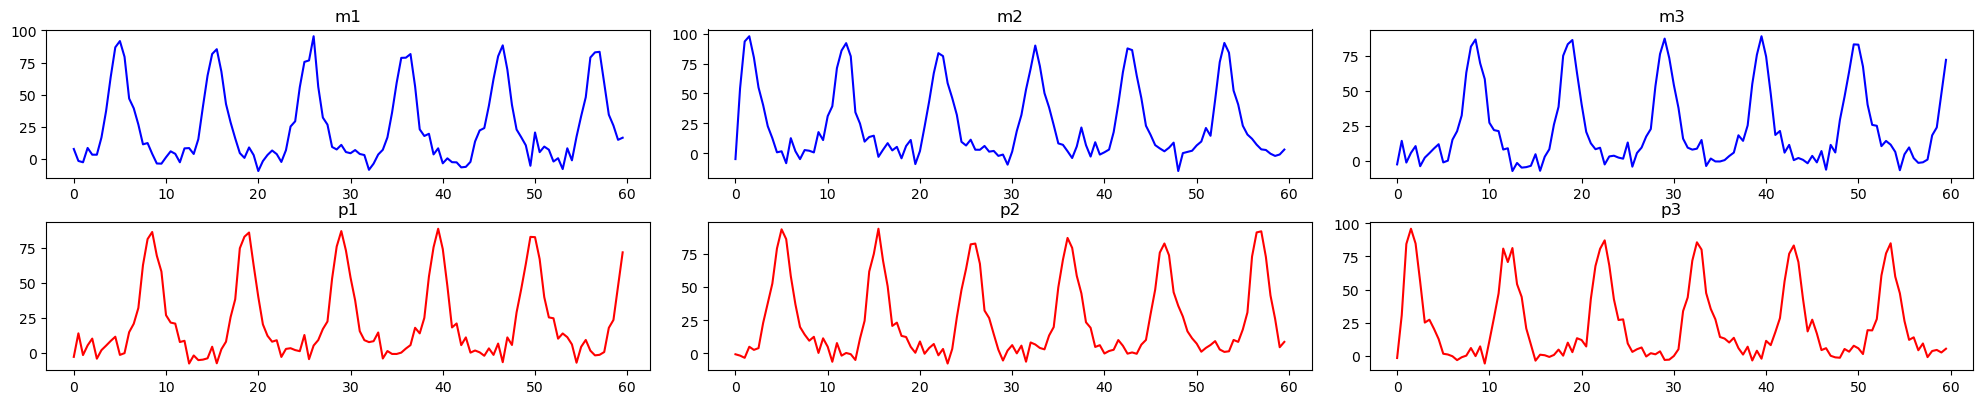

In [4]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params["t_points"]

fig_data, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
        else:
            title = "p"
            color = "r"

        axs[i, j].plot(t, y_real[2 * i + j], color)
        axs[i, j].set_title(title + str(j + 1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:** Yes, I use a mutation operator. I use Random Perturbation with Uniform Distribution. We sample random values from pdf of Uniform Distribution : y ∼ p(x) and then perturb the point: x′ = x + y. 

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
Yes, I use Uniform Recombination as a cross-over operator. Each parent is randomly selected from parents. First, children population is initialized. Two parents are selected randomly for each child. For each child a random r is generated and compared with value 0.5 uniformly, according to r being greater or smaller than 0.5, recombination is done with parent 1 or parent 2. Uniform recombination is used when creating children population. Then we return children population.

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
For parent selection, Proportional selection is used. I sampled according to the normalized fitness value.Fitness values are calculated by dividing each to sum of fitness values. This is actually a normalization process. I applied Tournament implementation to select parents according to probabilities. The algorithm selects participants randomly. Then the algortihm selects parents by comparing the value with parent's probability.
Proportional parent selection is used as it selects parents by checking their fitnesses. So the most fit parents have children. 

For survivor selection, Fitness Based Replacement is used with (μ, λ) selection. First old population and children gets concatanated with fitness values. According to fitness values, the population is sorted. The first λ children gets selected for the new population. In other words, we create λ children from μ s.t. λ > μ. And μ best children constitute a new population. The method returns new population with their fitness values. Fitness based survivor selection is used as it selects fittest survivors. Hence, the fittest offsprings are produced and the algorithm converges to the optimal solution.

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
No. I don't use any other operation.

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**

parent_selection(x_old, f_old):

    x_parents = x_old
    f_parents = f_old
    prob_parents = np.exp(-f_old)/ np.sum(np.exp(-f_old))   
    new_x, new_f = tournament_selection()
    x_parents.append(new_x)
    f_parents.append(new_f)            
    return x_parents, f_parents
    
*****************

recombination(x_parents, f_parents):
    
    x_children = [] 
    for i in range(self.pop_size):
        parent_1, parent_2 = np.random(num_parents)
         child_1 = np.zeros(len(parent_1))
         child_2 = np.zeros(len(parent_2))
         for j until len(parent_1):
             r = random number
             if r > 0.5:
                 child_1 has gene from parent 1
                 child_2 has gene from parent 2
             else:
                 child_1 has gene from parent 2
                 child_2 has gene from parent 1
         x_children add(child_1)
         x_children add(child_2)  
    return x_children

*****************
mutation(x_children):

        y = np.random.uniform(lower, upper, size =x_children.shape) # random sample from uniform distribution
        x_children = x_children + y # perturbation
        return x_children

*****************
survivor_selection(x_old, x_children, f_old, f_children):

    x = concatanate(x_old, x_children)
    f = concatanate(f_old, f_children)
    mu = length of x_old
    indices = argsort(f)
    x , f = sort according to indices
    x = select first mu children from x
    f = select firt mu children from f
    return selected x and f
    
*****************
step(x_old, f_old):

        x_parents, f_parents = parent_selection(x_old, f_old)
        x_children = recombination(x_parents, f_parents)
        x_children = mutation(x_children)
        f_children = evaluate(x_children)
        x, f = survivor_selection(x_old, x_children, f_old, f_children)

In [116]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
# =========
# Implement the Evolutionary Algorithm (EA) algorithm.
# It is equivalent to implementing the step function.
class EA(object):
    def __init__(self, repressilator, pop_size, bounds_min=None, bounds_max=None):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        # -------
        # PLEASE FILL IN
        # all necessary hyperparameters come here
        # -------

    # -------
    # PLEASE FILL IN
    # all necessary operations (e.g., mutation, selection) must come here.
    # -------

    def parent_selection(self, x_old, f_old):
        
        # Proportional selection with fitness values is used. Sampled according to the normalized fitness value.
        # Tournament implementation is used for selection
        # Tournament selection: Pick k individuals randomly (with or without replacement).
        # Pick the best one and add it to the matching pool.
        # Repeat
        x_parents = x_old
        f_parents = f_old
        # normalize fitness values and compute sum
        prob_parents = np.exp(-f_old)/ np.sum(np.exp(-f_old))
        x_parents = []
        f_parents = []
        mu = 2*self.pop_size
        for i in range(mu):
            # select parents with tournament selection with k=2
            k = 2
            participants = np.random.choice(len(x_old), k, replace=False)
            best = np.argmin(f_old[participants])
            x_parents.append(x_old[participants[best]])
            f_parents.append(f_old[participants[best]]) 
        x_parents = np.asarray(x_parents)
        f_parents = np.asarray(f_parents)
        return x_parents, f_parents

    def recombination(self, x_parents, f_parents):
        
        # For recombination, Uniform Recombination is used. 
        # children population is initialized. 
        # two parents are selected randomly. 
        # for each child a random r is generated and compared with value 0.5 uniformly 
        # according to r being greater or smaller than 0.5, recombination is done with parent 1 or parent 2.
        # uniform recombination is used when creating children.
        # empty list to store children
        x_children = []
        for i in range(self.pop_size):
            num_parents = x_parents.shape[0]
            # two parents are selected randomly. 
            parent_1 = x_parents[(np.floor(np.random.uniform(0, num_parents))).astype(int)]
            parent_2 = x_parents[(np.floor(np.random.uniform(0, num_parents))).astype(int)]
            child_1 = np.zeros(len(parent_1))
            child_2 = np.zeros(len(parent_2))
            for j in range(len(parent_1)):
                r = np.random.uniform(0, 1)
                # according to r being greater or smaller than 0.5, recombination is done with parent 1 or parent 2.
                if r>0.5:
                    child_1[j] = parent_1[j]
                    child_2[j] = parent_2[j]
                else:
                    child_1[j] = parent_2[j]
                    child_2[j] = parent_1[j]
            x_children.append(child_1)
            x_children.append(child_2)
        x_children = np.asarray(x_children)
        return x_children
    
    def mutation(self, x_children):
        # For mutation, Random Perturbation with uniform distribution between -1 and 1 is used. 
        # Upper and lower bounds are selected for uniform distribution.
        # we sample values from pdf of uniform distribution: y ∼ p(x)
        # then we perturb: x′ = x + y    
        
        # lower and upper range for uniform distribution
        lower = -1
        upper = 1
        # a random number is generated from uniform distribution
        y = np.random.uniform(lower, upper, x_children.shape)
        x_children = x_children + y # perturbation

        return x_children

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # For survivor selection, Fitness Based Replacement is used with (μ, λ) selection. 
        # We create λ children from μ s.t. λ > μ. And μ best children constitute a new population.
        # mu variable is the number of children that will be selected 
        
        # merge parent and child populations
        x = np.concatenate([x_old, x_children])
        f = np.concatenate([f_old, f_children])
        # give a value to mu variable
        mu = len(x_old)
        #sort by fitness values
        indices = np.argsort(f)
        x = x[indices]
        f = f[indices]
        # select μ best children and they constitute a new population, (μ, λ) selection is used
        x = x[:mu]
        f = f[:mu]
        return x, f

    # Evaluation step: DO NOT REMOVE!
    def evaluate(self, x):
        return self.repressilator.objective(x)

    def step(self, x_old, f_old):
        # -------
        # PLEASE FILL IN
        # NOTE: This function must return x, f
        # where x - population
        #       f - fitness values of the population
        # -------

        x_parents, f_parents = self.parent_selection(x_old, f_old)

        x_children = self.recombination(x_parents, f_parents)

        x_children = self.mutation(x_children)

        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f

**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best valyes of the hyperparameters here.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [121]:
# PLEASE DO NOT REMOVE!
num_generations = 50  # if necessary, please increase the number of generations
pop_size = 100
bounds_min = [-2.0, 0.0, -5.0, 0.0]
bounds_max = [10.0, 10.0, 20.0, 2500.0]
# -------
# PLEASE FILL IN!
# Your hyperparams go here.
# PLEASE USE THE VALUES OF THE HYPERPARAMETERS FOR WHICH YOU OBTAINED THE BEST RESULTS.
# DO NOT ITERATE OVER THEM!
# -------

# Initialize the repressilator
repressilator = Repressilator(y_real, params)

# -------
# PLEASE FILL IN!
# Your object goes here:
ea = EA(repressilator, pop_size)
# -------

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
    else:
        f_best.append(f_best[-1])
print("FINISHED!")

/var/folders/0m/4f8p309n38dgcm6s7hjkbtx00000gn/T/ipykernel_36484/2419548718.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
/var/folders/0m/4f8p309n38dgcm6s7hjkbtx00000gn/T/ipykernel_36484/2419548718.py:23: RuntimeWarning: invalid value encountered in double_scalars
  dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
/var/folders/0m/4f8p309n38dgcm6s7hjkbtx00000gn/T/ipykernel_36484/2419548718.py:25: RuntimeWarning: invalid value encountered in double_scalars
  dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0


Generation: 0, best fitness: 45.91
Generation: 5, best fitness: 22.34
Generation: 10, best fitness: 19.57
Generation: 15, best fitness: 15.70
Generation: 20, best fitness: 15.05
Generation: 25, best fitness: 13.80
Generation: 30, best fitness: 13.80
Generation: 35, best fitness: 13.80
Generation: 40, best fitness: 11.56
Generation: 45, best fitness: 11.56
FINISHED!


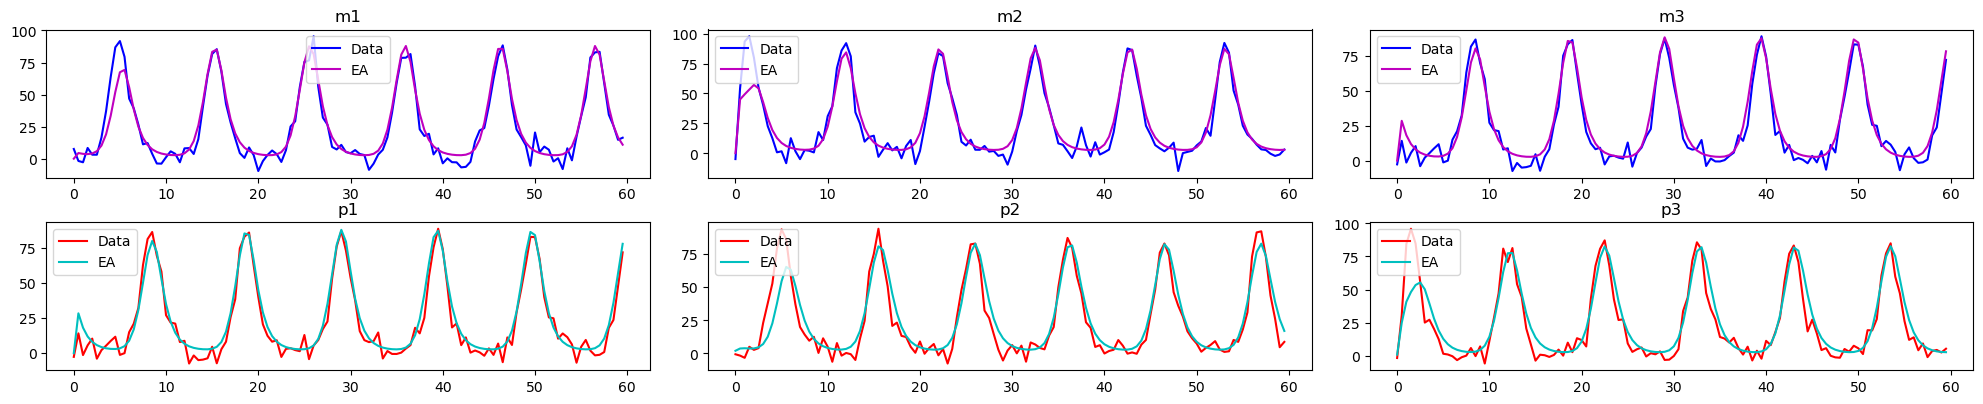

In [122]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(
    x[f.argmin()],
)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
            color_m = "m"
        else:
            title = "p"
            color = "r"
            color_m = "c"

        axs[i, j].plot(t, y_real[2 * i + j], color, label="Data")
        axs[i, j].plot(t, y_best[2 * i + j], color_m, label="EA")
        axs[i, j].set_title(title + str(j + 1))
        axs[i, j].legend()

Text(0.5, 1.0, '$n$ vs. $\\beta$')

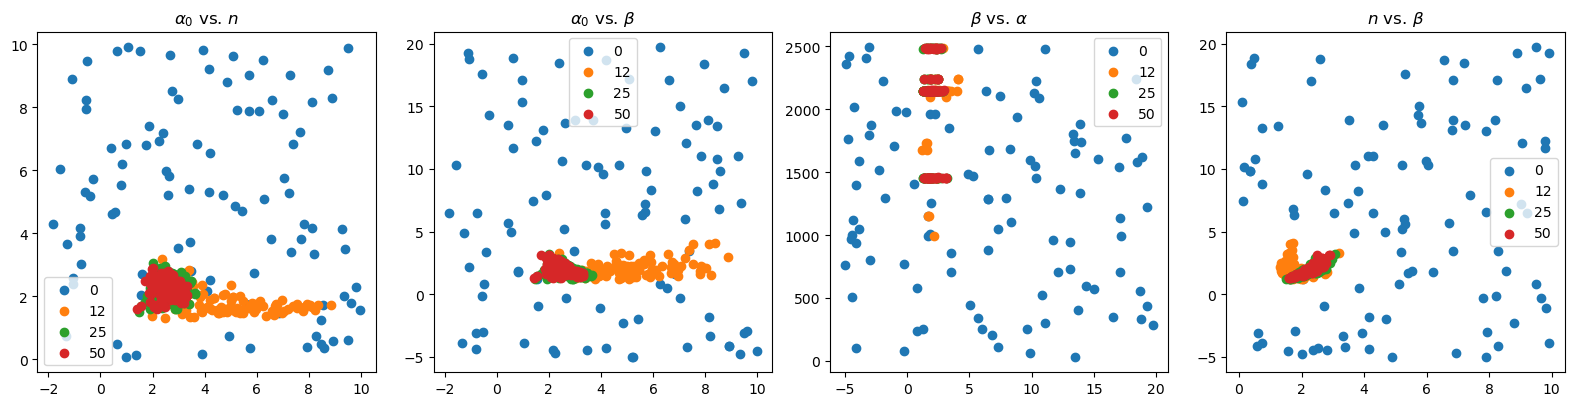

In [123]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations // 4, num_generations // 2, num_generations]
fig_ea_pops, axs = plt.subplots(1, 4, figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:, 0], pop_i[:, 1], label=str(gens[i]))
    axs[1].scatter(pop_i[:, 0], pop_i[:, 2], label=str(gens[i]))
    axs[2].scatter(pop_i[:, 2], pop_i[:, 3], label=str(gens[i]))
    axs[3].scatter(pop_i[:, 1], pop_i[:, 2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r"$\alpha_0$ vs. $n$")
axs[1].set_title(r"$\alpha_0$ vs. $\beta$")
axs[2].set_title(r"$\beta$ vs. $\alpha$")
axs[3].set_title(r"$n$ vs. $\beta$")

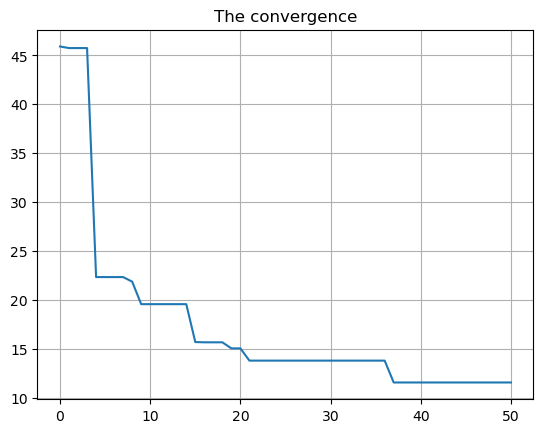

In [124]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: After analyzing the results, I think my algorithm discovered the real values of the parameters. Observing the results, the scatterplots of the populations and the convergence graph,  and especially from the data and EA graphs, we see that results converge to the real values. First plots indicate the similarity of real data to the outputs of the evolutionary algorithms. Second plots show the scatterplots of distributions of solutions in populations at different generations. The third graph shows the convergence of evolutionary algorithm within generations.

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: I ran my algorithm with different population sizes. I ran it with population size 25, 50, 75 and 100 and observed the convergence. Larger populations gave better solutions but it took more time to converge to the optimal solution. With bigger population sizes the algorithm performed better, had better results.

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: I think my algorithm discovered very similar values to real values of the parameters. Random perturbation with uniform distribution as mutation operator is helpful for spreading distributions the same way to the space. Uniform recombination is good in a way that children have traits from both parents. Proportional parent selection is favorable as it selects parents by checking their fitnesses. So the most fit parents have children. Also,  fitness based survivor selection selects fittest survivors. Hence, the fittest offsprings are produced and the algorithm converges to the optimal solution. 

**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: I guess the main drawback in my algorithm is that the population is not that diverse. It is because of the selected approaches in mutation and recombination parts. I used Random Perturbation with uniform distribution for mutation and Uniform Recombination. These were not that successful at generating different children. Maybe the diverseness could be checked in each generation and could be improved accordingly before going to the next generation. Also, maybe the convergence speed could be higher, it took some time to converge to optimal solution. 

**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**: I could improve convergence speed by increasing population size. Large populations create more diverse individuals which affects the convergence speed. By running the algorithm with different population sizes, I observed that in larger populations, the convergence is faster and it gives better results overall. 

**Question 11 (0-0.5pt)**: How does an EA compares with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: Both are optimization algorithms. They both use randomness of points. Evolution algorithms use evolutionary ways, different from Metropolis Hastings, it uses mutation and recombination and creates diversity also makes use of selection approaches. Evolutionary algorithms use a population whereas Metropolis-Hastings uses one solution. Evolutionary algorithms tries to converge to a solution. However, Metropolis-Hastings algorithms samples from a distribution. 